In [1]:
import pandas as pd


In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [3]:
df = pd.read_csv(r"C:/Users/Zeineb/Desktop/TEKUP/ProjetBI/table_prod.csv", on_bad_lines='skip') 

In [4]:
df.tail(5)

,id,name,price,stock,desc,pub_date,brand_id,category_id,image_1,discount,sales,active
133,2447,Robe midi à fleurs,49.99,120,Robe fleurie élégante,2025-02-12 00:00:00,23,10,robe_fleurs.jpg,6,180,1
134,2448,Chemise manches longues homme,29.99,110,Chemise formelle homme,2025-02-15 00:00:00,26,10,chemise_manches_longues.jpg,0,175,1
135,2449,Legging sport taille haute,24.99,70,Legging confortable sport,2025-03-22 00:00:00,27,10,legging_sport.jpg,5,185,1
136,2450,Montre sportive édition spéciale,899.99,0,Montre indisponible en stock pour le moment,2024-06-01 00:00:00,2,8,montre_sport_edition.jpg,15,100,1
137,2451,Casque VR économique,15.00,150,Casque réalité virtuelle bas de gamme,2024-02-28 00:00:00,9,5,vr_eco.jpg,5,1,1


In [5]:
df.describe()

,id,price,stock,brand_id,category_id,discount,sales,active
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
mean,2073.514493,84.121087,150.572464,8.297101,6.289855,12.282609,60.739130,1.0
std,802.085687,146.247528,101.887650,7.559409,3.560126,10.734343,50.342521,0.0
min,1.000000,5.990000,0.000000,1.000000,1.000000,0.000000,0.000000,1.0
25%,2334.250000,22.492500,80.000000,3.000000,4.000000,5.000000,32.000000,1.0
50%,2369.500000,39.990000,122.500000,6.000000,6.000000,10.000000,55.500000,1.0
75%,2415.750000,74.990000,210.000000,10.000000,9.750000,15.000000,87.750000,1.0
max,2451.000000,899.990000,500.000000,33.000000,11.000000,50.000000,240.000000,1.0


In [6]:
df.dtypes

id               int64
name            object
price          float64
stock            int64
desc            object
pub_date        object
brand_id         int64
category_id      int64
image_1         object
discount         int64
sales            int64
active           int64
dtype: object

In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

C:\Users\Zeineb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


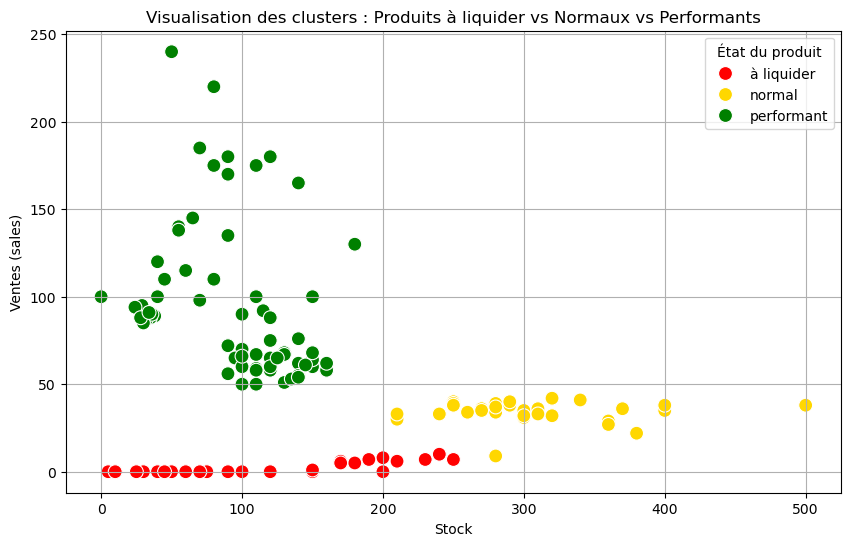

In [8]:
# 2. Calcul de l'ancienneté (age_en_jours)
df['pub_date'] = pd.to_datetime(df['pub_date'])
df['age_en_jours'] = (datetime.today() - df['pub_date']).dt.days

features = ['stock', 'sales', 'age_en_jours']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 6. Identifier le cluster à liquider (basé sur caractéristiques moyennes)
cluster_summary = df.groupby('cluster')[features].mean()
to_liquidate_cluster = cluster_summary.sort_values(by=['sales', 'stock', 'age_en_jours'], ascending=[True, False, False]).index[0]
df['etat'] = df['cluster'].apply(lambda c: 'à liquider' if c == to_liquidate_cluster else ('performant' if cluster_summary.loc[c]['sales'] > df['sales'].mean() else 'normal'))

# 7. Prédiction du discount (Régression linéaire sur produits déjà remisés)
discount_data = df[df['discount'] > 0].dropna(subset=['price'])
X_discount = discount_data[['stock', 'sales', 'age_en_jours', 'price']]
y_discount = discount_data['discount']

reg = LinearRegression()
reg.fit(X_discount, y_discount)

to_predict = df[df['etat'] == 'à liquider']
X_pred = to_predict[['stock', 'sales', 'age_en_jours', 'price']]
df.loc[to_predict.index, 'discount_pred'] = reg.predict(X_pred).round(2)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='stock', y='sales', hue='etat', palette={'à liquider': 'red', 'normal': 'gold', 'performant': 'green'}, s=100)
plt.title('Visualisation des clusters : Produits à liquider vs Normaux vs Performants')
plt.xlabel('Stock')
plt.ylabel('Ventes (sales)')
plt.legend(title='État du produit')
plt.grid(True)
plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Nombre de clusters trouvés (hors outliers): 3
Nombre de points considérés comme 'bruit' (outliers): 10
Silhouette Score: 0.446


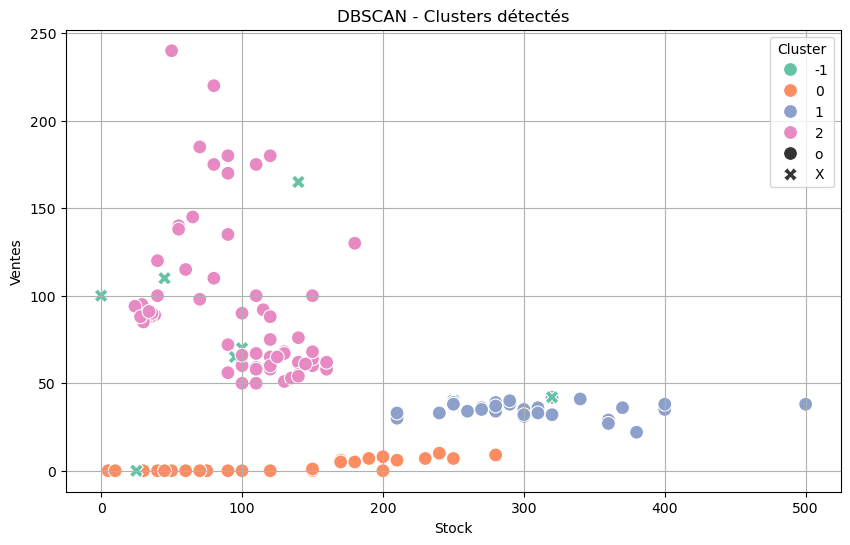

In [10]:
# 2. Calcul de l'ancienneté
df['pub_date'] = pd.to_datetime(df['pub_date'])
df['age_en_jours'] = (datetime.today() - df['pub_date']).dt.days

# 3. Sélection des variables
features = ['stock', 'sales', 'age_en_jours', 'price']
X = df[features].dropna()

# 4. Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. DBSCAN
db = DBSCAN(eps=1, min_samples=5)  
clusters = db.fit_predict(X_scaled)

# 6. Affecter les clusters au DataFrame
df_clean = df.loc[X.index].copy()
df_clean['cluster'] = clusters

# 7. Nombre de clusters (hors outliers)
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_outliers = list(clusters).count(-1)

print(f"Nombre de clusters trouvés (hors outliers): {n_clusters}")
print(f"Nombre de points considérés comme 'bruit' (outliers): {n_outliers}")

# 8. Silhouette Score (si au moins 2 clusters)
if n_clusters >= 2:
    score = silhouette_score(X_scaled, clusters)
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Silhouette Score non calculé (moins de 2 clusters détectés)")

plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set2", len(set(clusters)))
sns.scatterplot(
    data=df_clean, x='stock', y='sales', hue='cluster',
    palette=palette, s=100, style=(df_clean['cluster'] == -1).map({True: 'X', False: 'o'})
)
plt.title('DBSCAN - Clusters détectés')
plt.xlabel('Stock')
plt.ylabel('Ventes')
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [11]:
cluster_summary = df_clean.groupby('cluster')[['stock', 'sales', 'age_en_jours', 'price']].mean().round(2)
print(cluster_summary)

          stock  sales  age_en_jours   price
cluster                                     
-1       110.30  75.40        530.10  553.89
 0       128.04   2.54        222.04   56.21
 1       307.24  34.72       1179.07   44.06
 2       101.14  92.25        425.56   45.33


In [12]:
def label_cluster(row):
    if row['cluster'] == 2:
        return "Performants"
    elif row['cluster'] == 0:
        return "À liquider"
    
    elif row['cluster'] == 1:
        return "Normaux"
    else:
        return "Autre"

df_clean['etat'] = df_clean.apply(label_cluster, axis=1)

In [13]:
# Afficher les produits classés "À liquider"
produits_a_liquider = df_clean[df_clean['etat'] == 'À liquider']

print("Produits à liquider (IDs) :")
print(produits_a_liquider['id'].tolist()) 
produits_a_liquider['id'].count()

Produits à liquider (IDs) :
[1, 2, 4, 5, 6, 7, 8, 9, 14, 16, 17, 18, 19, 20, 21, 22, 23, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2451]


28

In [14]:
# Affichage de 5 produits à liquider choisis aléatoirement
produits_pub = produits_a_liquider.sample(n=5, random_state=1)  # Change n selon le nombre voulu

produits_pub[['id', 'stock', 'sales', 'age_en_jours', 'price']]


,id,stock,sales,age_en_jours,price
119,2433,210,6,484,25.0
112,2426,250,7,471,15.0
114,2428,200,8,474,12.0
115,2429,180,5,495,30.0
15,21,60,0,58,39.0


## Random forest classification

In [23]:
df_classif[['stock', 'sales', 'age_en_jours', 'price']]

NameError: name 'df_classif' is not defined

In [25]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1. Filtrer les produits qui ont un cluster attribué (hors outliers -1)
df_classif = df_clean[df_clean['cluster'] != -1].copy()

# 2. Features et Target
features = ['stock', 'sales', 'age_en_jours', 'price']
X = df_classif[features]
y = df_classif['cluster']

# # 3. Normalisation
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# 4. Split en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)


# 3. Normalisation
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)


# 5. Entraînement du modèle (RandomForest Classifier)
clf = RandomForestClassifier(n_estimators=3, random_state=100)
clf.fit(x_train_scaled, y_train)

x_test_scaled = scaler.transform(X_test)

# 6. Évaluation
y_pred = clf.predict(x_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.70      0.88      0.78         8
           2       1.00      1.00      1.00        24

    accuracy                           0.90        39
   macro avg       0.83      0.82      0.81        39
weighted avg       0.90      0.90      0.89        39



In [29]:
from sklearn.metrics import accuracy_score

# Affichage uniquement de l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.2f}")

Accuracy : 0.90


In [ ]:
import joblib

# Sauvegarde du modèle de classification
joblib.dump(clf, 'C:/Users/Zeineb/Desktop/TEKUP/ProjetBI/modelF/final/modele_classificationFinallll.pkl')

# Sauvegarde du scaler
joblib.dump(scaler, 'C:/Users/Zeineb/Desktop/TEKUP/ProjetBI/modelF/final/scaler_classificationFinallll.pkl')

In [ ]:
print("Features attendues par le scaler :", scaler.n_features_in_)


In [ ]:
def predire_etat_produit(stock, sales, age_en_jours, price):
    data_input = np.array([[stock, sales, age_en_jours, price]])
    data_scaled = scaler.transform(data_input)
    cluster_pred = clf.predict(data_scaled)[0]
    
    label_map = {
        0: "À liquider",
        1: "À liquider",
        2: "Normaux",
        3: "Performants"
    }
    
    return label_map.get(cluster_pred, "Autre")

etat = predire_etat_produit(stock=500, sales=10, age_en_jours=30, price=20)
print("Classe prédite :", etat)


In [ ]:
print("Répartition des classes :")
print(y.value_counts())

# Vérifie s'il y a des doublons entre X_train et X_test
train_rows = set(map(tuple, X_train))
test_rows = set(map(tuple, X_test))
overlap = train_rows.intersection(test_rows)
print("Nombre de doublons entre train et test :", len(overlap))


In [ ]:

# 4. Filtrer les produits à liquider
produits_a_liquider = df_classif[df_classif['etat'] == "À liquider"]

# 5. Afficher les IDs
print("IDs des produits à liquider :")
print(produits_a_liquider['id'].tolist())

In [ ]:
print("X_scaled shape:", X_scaled.shape)
print("y shape:", y.shape)


In [ ]:
#from sklearn.model_selection import cross_val_score

#scores = cross_val_score(tree_clf, X_scaled, y, cv=5)
#print("Scores cross-validation:", scores)
#print("Score moyen:", scores.mean())


### RandomForestRegressor


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Charger tes données filtrées (produits à liquider)
# Si tu pars de df_clean, fais :
produits_a_liquider = df_clean[df_clean['etat'] == 'À liquider'].copy()

# 1. Normalisation des features pour créer un score de discount
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(produits_a_liquider[['stock', 'age_en_jours', 'sales', 'price']])
produits_a_liquider[['stock_scaled', 'age_scaled', 'sales_scaled', 'price_scaled']] = scaled_features

# 2. Générer un score pondéré
produits_a_liquider['discount_score'] = (
    0.5 * produits_a_liquider['stock_scaled'] +
    0.4 * produits_a_liquider['age_scaled'] +
    0.3 * (1 - produits_a_liquider['sales_scaled']) +
    0.2 * produits_a_liquider['price_scaled']
)

# 3. Générer le discount cible entre 0.4 et 0.8
produits_a_liquider['discount'] = (
    0.4 + 0.4 * produits_a_liquider['discount_score']
).clip(0.4, 0.8)

produits_a_liquider.drop(columns=['stock_scaled', 'age_scaled', 'sales_scaled', 'price_scaled', 'discount_score'], inplace=True)


features_discount = ['stock', 'sales', 'age_en_jours', 'price']
X_discount = produits_a_liquider[features_discount]
y_discount = produits_a_liquider['discount']

X_train, X_test, y_train, y_test = train_test_split(X_discount, y_discount, test_size=0.2, random_state=42)

reg = RandomForestRegressor(n_estimators=7, random_state=42)
reg.fit(X_train, y_train)


y_pred = reg.predict(X_test)
print("MAE:", round(mean_absolute_error(y_test, y_pred), 4))
print("R² Score:", round(r2_score(y_test, y_pred), 4))

produits_a_liquider['predicted_discount'] = reg.predict(X_discount)



In [ ]:
print(produits_a_liquider[['id','stock', 'sales', 'age_en_jours', 'price', 'predicted_discount']].head(40))


In [ ]:
import joblib

In [ ]:
# Sauvegarder le modèle de régression (discount)
joblib.dump(reg, 'C:/Users/Zeineb/Desktop/TEKUP/ProjetBI/modelF/final/modele_discountFinallll.pkl')

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# 1. Normalisation
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(produits_a_liquider[['stock', 'age_en_jours', 'sales', 'price']])
produits_a_liquider[['stock_scaled', 'age_scaled', 'sales_scaled', 'price_scaled']] = scaled_features

# 2. Génération d'un score synthétique
produits_a_liquider['discount_score'] = (
    0.4 * produits_a_liquider['stock_scaled'] +
    0.3 * produits_a_liquider['age_scaled'] +
    0.2 * (1 - produits_a_liquider['sales_scaled']) +
    0.1 * produits_a_liquider['price_scaled']
)

# 3. Création du discount (entre 0.4 et 0.8)
produits_a_liquider['discount'] = (
    0.4 + 0.4 * produits_a_liquider['discount_score']
).clip(0.4, 0.8)

# 4. Préparation des données
produits_a_liquider.drop(columns=['stock_scaled', 'age_scaled', 'sales_scaled', 'price_scaled', 'discount_score'], inplace=True)

features_discount = ['stock', 'sales', 'age_en_jours', 'price']
X_discount = produits_a_liquider[features_discount]
y_discount = produits_a_liquider['discount']

# 5. Split
X_train, X_test, y_train, y_test = train_test_split(
    X_discount, y_discount, test_size=0.2, random_state=42
)

# 6. Entraînement du modèle Gradient Boosting
gbr =GradientBoostingRegressor(n_estimators=7, learning_rate=0.05, max_depth=2)

gbr.fit(X_train, y_train)

# 7. Évaluation
y_pred = gbr.predict(X_test)
print("MAE (GradientBoosting):", round(mean_absolute_error(y_test, y_pred), 4))
print("R2 Score (GradientBoosting):", round(r2_score(y_test, y_pred), 4))

# 8. Prédictions complètes
produits_a_liquider['predicted_discount'] = gbr.predict(X_discount)

# 9. Affichage des résultats
print(produits_a_liquider[['stock', 'sales', 'age_en_jours', 'price', 'predicted_discount']].head(10))


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Features et cible déjà préparées
X_discount = produits_a_liquider[['stock', 'sales', 'age_en_jours', 'price']]
y_discount = produits_a_liquider['discount']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_discount, y_discount, test_size=0.2, random_state=42
)

# Modèle XGBoost
xgb_model = XGBRegressor(
    n_estimators=7,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

# Entraînement
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred = xgb_model.predict(X_test)

# Évaluation
print("MAE (XGBoost):", round(mean_absolute_error(y_test, y_pred), 4))
print("R2 Score (XGBoost):", round(r2_score(y_test, y_pred), 4))

# Prédiction sur tous les produits à liquider
produits_a_liquider['predicted_discount'] = xgb_model.predict(X_discount)

# Affichage
print(produits_a_liquider[['stock', 'sales', 'age_en_jours', 'price', 'predicted_discount']].head(10))


In [ ]:
pip install lightgbm


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Créer le modèle LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# 2. Entraîner le modèle
lgb_model.fit(X_train, y_train)

# 3. Prédictions sur les données de test
y_pred_lgb = lgb_model.predict(X_test)

# 4. Évaluation
print("MAE (LightGBM):", round(mean_absolute_error(y_test, y_pred_lgb), 4))
print("R² Score (LightGBM):", round(r2_score(y_test, y_pred_lgb), 4))

# 5. Prédiction sur tous les produits à liquider
produits_a_liquider['predicted_discount_lgb'] = lgb_model.predict(X_discount)

# 6. Affichage des premières lignes
print(produits_a_liquider[['id','stock', 'sales', 'age_en_jours', 'price', 'predicted_discount_lgb']].head(10))


In [ ]:
# 1. Normalisation de chaque feature entre 0 et 1 pour les pondérer ensemble
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(produits_a_liquider[['stock', 'age_en_jours', 'sales', 'price']])
produits_a_liquider[['stock_scaled', 'age_scaled', 'sales_scaled', 'price_scaled']] = scaled_features

# 2. Générer un score combiné basé sur les poids que tu peux ajuster
# Plus stock et age sont élevés → +discount ; Plus sales est bas → +discount
# On inverse sales pour refléter ça
produits_a_liquider['discount_score'] = (
    0.4 * produits_a_liquider['stock_scaled'] +
    0.3 * produits_a_liquider['age_scaled'] +
    0.2 * (1 - produits_a_liquider['sales_scaled']) +  # moins de ventes = +discount
    0.1 * produits_a_liquider['price_scaled']
)

# 3. Générer un discount entre 0.4 et 0.8
produits_a_liquider['discount'] = (
    0.4 + 0.4 * produits_a_liquider['discount_score']  # Échelle de 0.4 à 0.8
).clip(0.4, 0.8)

# 4. Supprimer les colonnes intermédiaires si tu veux
produits_a_liquider.drop(columns=['stock_scaled', 'age_scaled', 'sales_scaled', 'price_scaled', 'discount_score'], inplace=True)


In [ ]:
features_discount = ['stock', 'sales', 'age_en_jours', 'price']

X_discount = produits_a_liquider[features_discount]
y_discount = produits_a_liquider['discount']

In [ ]:
import joblib

In [ ]:
# 9. Sauvegarde du modèle et du scaler
joblib.dump(reg, 'C:/Users/Zeineb/Desktop/TEKUP/ProjetBI/models/discount_model.pkl')
joblib.dump(scaler, 'C:/Users/Zeineb/Desktop/TEKUP/ProjetBI/models/scaler_discount.pkl')


In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report

# 1. Charger le modèle et le scaler
model_clf = joblib.load('C:/Users/Zeineb/Desktop/TEKUP/ProjetBI/models/produit_etat_model.pkl')
scaler_clf = joblib.load('C:/Users/Zeineb/Desktop/TEKUP/ProjetBI/models/scaler.pkl')

# 2. Assure-toi que df_clean existe déjà (ex: déjà chargé avant)
# df_clean = pd.read_csv("...") ou utilisé dans un notebook précédent

# 3. Nettoyage de base (si ce n'est pas déjà fait)
df_clean['pub_date'] = pd.to_datetime(df_clean['pub_date'], errors='coerce')
df_clean['age_en_jours'] = (pd.Timestamp.today() - df_clean['pub_date']).dt.days
df_clean = df_clean.dropna(subset=['stock', 'sales', 'price', 'age_en_jours'])

# 4. Préparation des features
features_clf = ['stock', 'sales', 'age_en_jours', 'price']
X = df_clean[features_clf]
X_scaled = scaler_clf.transform(X)

# 5. Prédiction
df_clean['etat_pred'] = model_clf.predict(X_scaled)

# 6. Afficher les prédictions vs les vraies valeurs
print("🔍 Comparaison entre étiquettes réelles et prédictions :")
print(df_clean[['id', 'etat', 'etat_pred']].head(10))

# 7. Optionnel : rapport de classification
if 'etat' in df_clean.columns:
    # Convertir les étiquettes textuelles en 0/1 si besoin
    df_clean['etat_true_num'] = df_clean['etat'].apply(lambda x: 1 if x == 'À liquider' else 0)
    print("\n📊 Rapport de classification :")
    print(classification_report(df_clean['etat_true_num'], df_clean['etat_pred']))
